# Trabajo Práctico 1: Enunciado


El trabajo práctico 1 de la materia se basa en el análisis de los tweets del set de datos de la competencia: https://www.kaggle.com/c/nlp-getting-started.  

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)

El objetivo del primer TP es realizar un análisis exploratorio del set de datos. Queremos ver qué cosas podemos descubrir sobre los datos que puedan resultar interesantes. Estas cosas pueden estar relacionadas al objetivo del TP2 (predecir si un cierto tweet es real o no) o no, ambas son de interés.

Los requisitos de la primera entrega son los siguientes:

- El análisis debe estar hecho en Python Pandas o R.
- El análisis debe entregarse en formato pdf vía gradescope. En el informe no va código.
- Informar el link a un repositorio Github en donde pueda bajarse el código completo para generar el análisis.

La evaluación del TP se realizará en base al siguiente criterio:

- Originalidad del análisis exploratorio. 
- Calidad del reporte. ¿Está bien escrito? ¿Es claro y preciso? 
- Calidad del análisis exploratorio: qué tipo de preguntas se hacen y de qué forma se responden, ¿es la respuesta clara y concisa con respecto a la pregunta formulada? 
- Calidad de las visualizaciones presentadas.
  - ¿Tienen todos los ejes su rótulo?
  - ¿Tiene cada visualización un título?
  - ¿Es entendible la visualización sin tener que leer la explicación?
  - ¿El tipo de plot elegido es adecuado para lo que se quiere visualizar?
  - ¿Es una visualización interesante?
  - ¿El uso del color es adecuado?
  - ¿Hay un exceso o falta de elementos visuales en la visualización elegida?
  - ¿La visualización es consistente con los datos?
- Conclusiones presentadas.


In [296]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs


In [297]:
tweets = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [298]:
# keyword tiene 61 nulls
# location tiene 2533 nulls

In [299]:
tweets.location.value_counts() # se podría unificar varios a USA

USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
Trapped in my Conscience          1
North-East Region, Singapore      1
Dammam- KSA                       1
Milton keynes                     1
Soufside                          1
Name: location, Length: 3341, dtype: int64

### Análisis de los falsos

In [300]:
tweets[tweets["target"] == 0]["text"] #los falsos

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [301]:
# primera normalización del texto, pasamos a lowercase 
tweets['normalized_text'] = tweets.text.str.lower()

#### Eliminamos los links del texto y dejandolos en una columna a parte por si sirven a futuro

In [302]:
# nueva columna con el total de links
import re
URLPATTERN = r'(https?://\S+)' 

tweets['urls'] = tweets.normalized_text.apply(lambda x: re.findall(URLPATTERN, x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(URLPATTERN,"", x))
# cuento la cantidad de links en los tweets
tweets['url_count'] = tweets.urls.str.len()

In [303]:
tweets[tweets["target"] == 1].keyword.value_counts() #los posta, keywords

outbreak       39
derailment     39
wreckage       39
debris         37
oil%20spill    37
               ..
ruin            1
body%20bags     1
electrocute     1
body%20bag      1
epicentre       1
Name: keyword, Length: 220, dtype: int64

In [304]:
# vemos como queda el dataset
tweets[(tweets['url_count'] > 1)].head()

,id,keyword,location,text,target,normalized_text,urls,url_count
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check these out: #nsfw,"[http://t.co/roi2nsmejj, http://t.co/3tj8zjin2...",4
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check these out: #nsfw,"[http://t.co/roi2nsmejj, http://t.co/3tj8zjin2...",4
52,76,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0,santa cruz ûó head of the st elizabeth police...,"[http://t.co/vplr5hka2u, http://t.co/sxhw2tnnlf]",2
59,83,ablaze,"Edmonton, Alberta - Treaty 6",How the West was burned: Thousands of wildfire...,1,how the west was burned: thousands of wildfire...,"[http://t.co/icsjgz9te1, http://t.co/9fxmn0l0bd]",2
71,102,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Speeding Among Top...,0,#stlouis #caraccidentlawyer speeding among top...,"[https://t.co/k4zomof319, https://t.co/s2kxvm0...",2


#### Eliminando palabras que no son super importantes

In [305]:
!pip3 install nltk
!pip3 install stopwords

In [306]:
#import nltkfrom nltk.corpus 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [307]:
stop_words = stopwords.words('english')
stop_words[1:15]

['me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [308]:
# cuento la cantidad de hashtags en los tweets
# nueva columna con el total de hashtags, y los hashtags
tweets['hashtags'] = tweets.normalized_text.apply(lambda x: re.findall(r"#(\w+)", x))
tweets['hashtags_count'] = tweets.hashtags.str.len()
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"#(\w+)","", x))

In [309]:
# vemos como queda el dataset
tweets[(tweets['hashtags_count'] > 1)].head()

,id,keyword,location,text,target,normalized_text,urls,url_count,hashtags,hashtags_count
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby as smoke f...,[],0,"[alaska, wildfires]",2
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,update => california hwy. 20 closed in both d...,[],0,"[rockyfire, cafire, wildfires]",3
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,heavy rain causes flash flooding of streets ...,[],0,"[flood, disaster]",2
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1,18 or 19 days. i've lost count,[],0,"[raining, flooding, florida, tampabay, tampa]",5
13,19,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1,in bago myanmar arrived bago,[],0,"[flood, we]",2


#### Eliminamos los tags del texto y lo dejamos en otra columna junto con el count

In [310]:
# cuento la cantidad de ags en los tweets
# nueva columna con el total de tags, y los tags
tweets['tags'] = tweets.text.str.lower().apply(lambda x: re.findall(r"@(\w+)", x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"@(\w+)","", x))
tweets['tags_count'] = tweets.tags.str.len()

In [311]:
# vemos como queda el dataset
tweets[(tweets['tags_count'] > 1)].head()

,id,keyword,location,text,target,normalized_text,urls,url_count,hashtags,hashtags_count,tags,tags_count
63,91,ablaze,"Concord, CA",@Navista7 Steve these fires out here are somet...,1,steve these fires out here are something else...,[],0,[],0,"[navista7, news24680]",2
135,195,aftershock,NaN,Anyone need a P/U tonight? I play Hybrid Slaye...,0,anyone need a p/u tonight? i play hybrid slaye...,[],0,[],0,"[cod8sandscrims, empirikgaming, codawscrims, 4...",6
150,215,airplane%20accident,"New Mexico, USA",@mickinyman @TheAtlantic That or they might be...,0,that or they might be killed in an airplane ...,[],0,[],0,"[mickinyman, theatlantic]",2
180,258,ambulance,Arizona,@20skyhawkmm20 @traplord_29 @FREDOSANTANA300 @...,1,it was hella crazy 3 fights an ambulance a...,[],0,[],0,"[20skyhawkmm20, traplord_29, fredosantana300, ...",4
188,267,ambulance,"Williamstown, VT",@TheNissonian @RejectdCartoons nissan are you ...,0,nissan are you ok do you need medical assist...,[],0,[],0,"[thenissonian, rejectdcartoons]",2


#### Contador de links (DESCARTADO)
Quiero ver si hay relación entre cantidad de tweets fakes y no fakes y la cantidad de links (DESCARTADO)

In [312]:
# cuento la cantidad de links en los tweets
import re
URLPATTERN = r'(https?://\S+)' 
# nueva columna con el total de links
tweets['url_count'] = tweets.text.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
tweets.head()

,id,keyword,location,text,target,normalized_text,urls,url_count,hashtags,hashtags_count,tags,tags_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this may allah fo...,[],0,[earthquake],1,[],0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,[],0,[],0,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,[],0,[],0,[],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive evacuation orders in ca...",[],0,[wildfires],1,[],0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby as smoke f...,[],0,"[alaska, wildfires]",2,[],0


In [313]:
tweets[tweets["target"] == 1].url_count.value_counts() #los posta, cantidad de urls

1    1835
0    1099
2     328
3       9
Name: url_count, dtype: int64

In [314]:
tweets[tweets["target"] == 0].url_count.value_counts() #los fake, cantidad de urls

0    2543
1    1414
2     369
3      13
4       3
Name: url_count, dtype: int64

Text(0, 0.5, 'Cantidad de links')

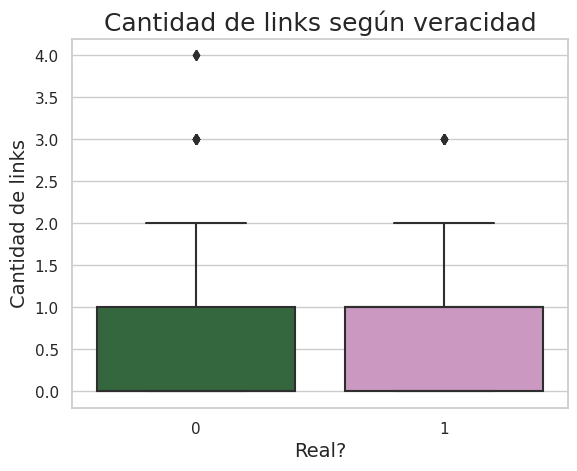

In [315]:
# grafico esto para ver si hay relación
g = sns.boxplot(x="target", y="url_count", 
                     data=tweets, palette="cubehelix")
g.set_title("Cantidad de links según veracidad", fontsize=18)
g.set_xlabel("Real?", fontsize=14)
g.set_ylabel("Cantidad de links", fontsize=14)

In [316]:
import string
translator = str.maketrans('', '', string.punctuation)

# !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuation(text):        
    return text.translate(translator)

In [317]:
!pip install bs4

In [318]:
from bs4 import BeautifulSoup
from html import unescape

In [319]:
def remove_htmlsymbols(text):
    soup = BeautifulSoup(unescape(text))
    return soup.text

In [320]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def remove_emojis_non_ascii(text):    
    #replace consecutive non-ASCII characters with a space
    result = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    result = emoji_pattern.sub(r'', result)    
    return result

In [321]:
tweets['normalized_text'] = tweets.normalized_text.apply(remove_htmlsymbols)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_punctuation)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_emojis_non_ascii)

In [322]:
#### Eliminamos stop words y creamos nueva columna con array de palabras

In [323]:
!pip install nltk
!pip install stopwords

In [324]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [325]:
# convertimos el texto en listado de palabras y despues borramos las stop words
tweets['words'] = tweets.normalized_text.str.split()
stop_words = stopwords.words('english')
tweets['normalized_words'] = tweets['words'].apply(lambda x: [item for item in x if item not in stop_words])
# eliminar las stop words del texto normalizado
tweets['normalized_text'] = [' '.join(map(str, l)) for l in tweets['normalized_words']]
# vemos como queda el dataset
tweets.head()

,id,keyword,location,text,target,normalized_text,urls,url_count,hashtags,hashtags_count,tags,tags_count,words,normalized_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,[],0,[earthquake],1,[],0,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,[],0,[],0,[],0,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,[],0,[],0,[],0,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,[],0,[wildfires],1,[],0,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,[],0,"[alaska, wildfires]",2,[],0,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]"


In [326]:
# todos los tags
tweets.text.str.extractall(r'(\@\w+)')[0].value_counts()


@YouTube           82
@ArianaGrande      11
@Change             9
@POTUS              9
@FoxNews            9
                   ..
@laevantine         1
@Jason_Floyd        1
@RomeoCrow          1
@Lolly_Knickers     1
@DalaiLama          1
Name: 0, Length: 2326, dtype: int64

In [327]:
tweets[tweets["target"] == 1].tags_count.value_counts() #los posta

0    2605
1     512
2     101
3      39
4      11
5       3
Name: tags_count, dtype: int64

In [328]:
tweets[tweets["target"] == 0].tags_count.value_counts() #los fake}

0    2999
1    1019
2     237
3      47
4      19
5      14
6       5
7       1
8       1
Name: tags_count, dtype: int64

Text(0, 0.5, 'Cantidad de tags')

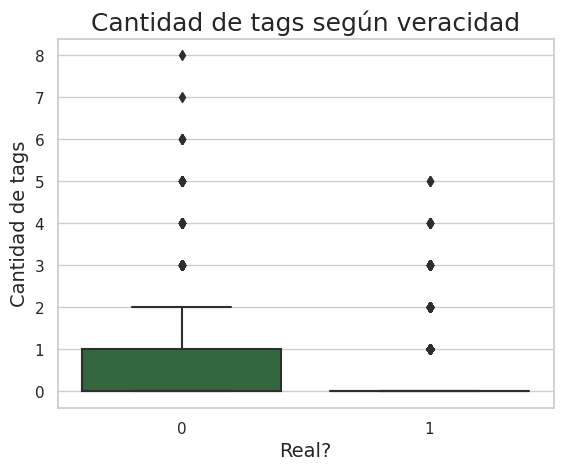

In [329]:
# grafico esto para ver si hay relación
g = sns.boxplot(x="target", y="tags_count", 
                     data=tweets, palette="cubehelix")
g.set_title("Cantidad de tags según veracidad", fontsize=18)
g.set_xlabel("Real?", fontsize=14)
g.set_ylabel("Cantidad de tags", fontsize=14)

#### Analizamos si el texto tiene números y guardamos el dato en una nueva columna

In [330]:
tweets.corr()

,id,target,url_count,hashtags_count,tags_count
id,1.00,0.06,0.01,0.00,-0.03
target,0.06,1.00,0.20,0.05,-0.10
url_count,0.01,0.20,1.00,0.17,-0.22
hashtags_count,0.00,0.05,0.17,1.00,-0.04
tags_count,-0.03,-0.10,-0.22,-0.04,1.00


### Análisis de location

In [331]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Analisis sobre cuestiones vistas despues de la reunion con Vir.

- Analisis de Tweets c/location vs Tweets s/location
- Keywords / Palabras y veracidad
- Relacion entre location - existencia en el texto


### Analisis de Tweets c/location vs tweets s/location

In [332]:
#cantidad de tweets con y sin location
tweets['location'].isna().value_counts()

False    5080
True     2533
Name: location, dtype: int64

In [333]:
#tweets reales y no
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [367]:
#relacion entre ambos datos
tweets['has_location'] = ~tweets['location'].isna()
tweets[['has_location','target']].groupby(['target']).count()
#no aporta nada.

,has_location
target,
0,4342
1,3271


In [368]:
##tweets['---'] = tweets.text.str.contains(tweets.has_location)
#apply( =>)
#revisar esto, como buscar string en columna
# eliminamos "%20" que representa espacio
tweets['keyword'] = tweets['keyword'].str.replace('\s','%20')

In [469]:
#"apariciones / total de tweets" va a dar una aproximacion mejor de la ponderacion de las palabras sobre los tweets
total_keyword = tweets['keywords'].value_counts().count()
total_keyword

222

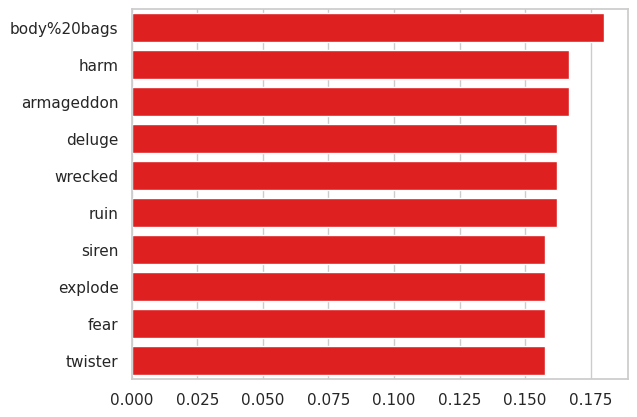

In [479]:
#relacion entre keywords y verac
keyword_false = tweets[tweets["target"] == 0]["keyword"].value_counts() /total_keyword
keyword_true  = tweets[tweets["target"] == 1]["keyword"].value_counts() /total_keyword

g = sns.barplot(x=keyword_false.head(10).values,y=keyword_false.head(10).index,color='red',orient="h")

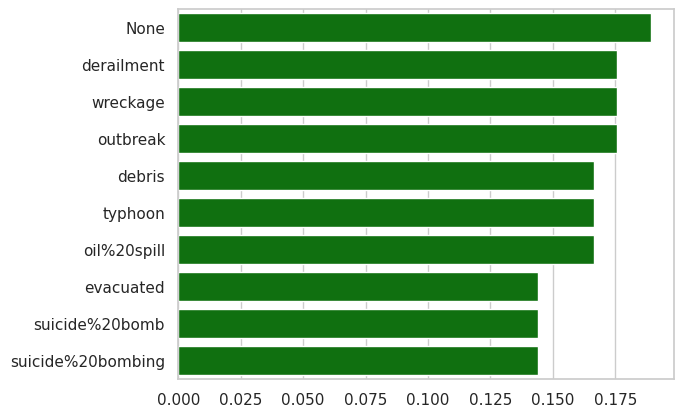

In [471]:
#keyword_false.merge(keyword_real)
f = sns.barplot(x=keyword_true.head(10).values,y=keyword_true.head(10).index,color='green',orient="h")

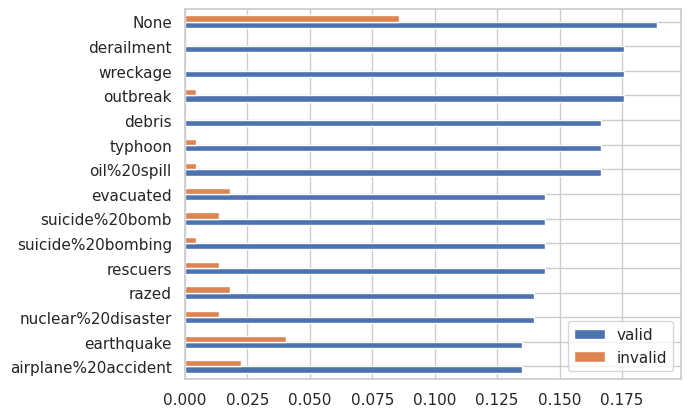

In [483]:
#comparacion entre datasets?. buscar palabras en tops. - pendiente comparacion entre dos datasets
comparewords = pd.concat([keyword_true,keyword_false], axis=1)
comparewords.columns=['valid','invalid']

comparewords = comparewords.fillna(0)
comparewords = comparewords.sort_values(by=['valid'])

#comparewords_ds.plot.barh(rot=0)
comparewords.tail(15).plot.barh(rot=0)


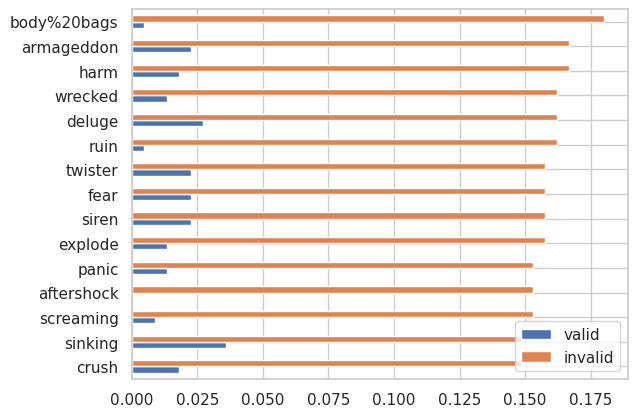

In [484]:
comparewords = comparewords.sort_values(by=['invalid'])
comparewords.tail(15).plot.barh(rot=0)

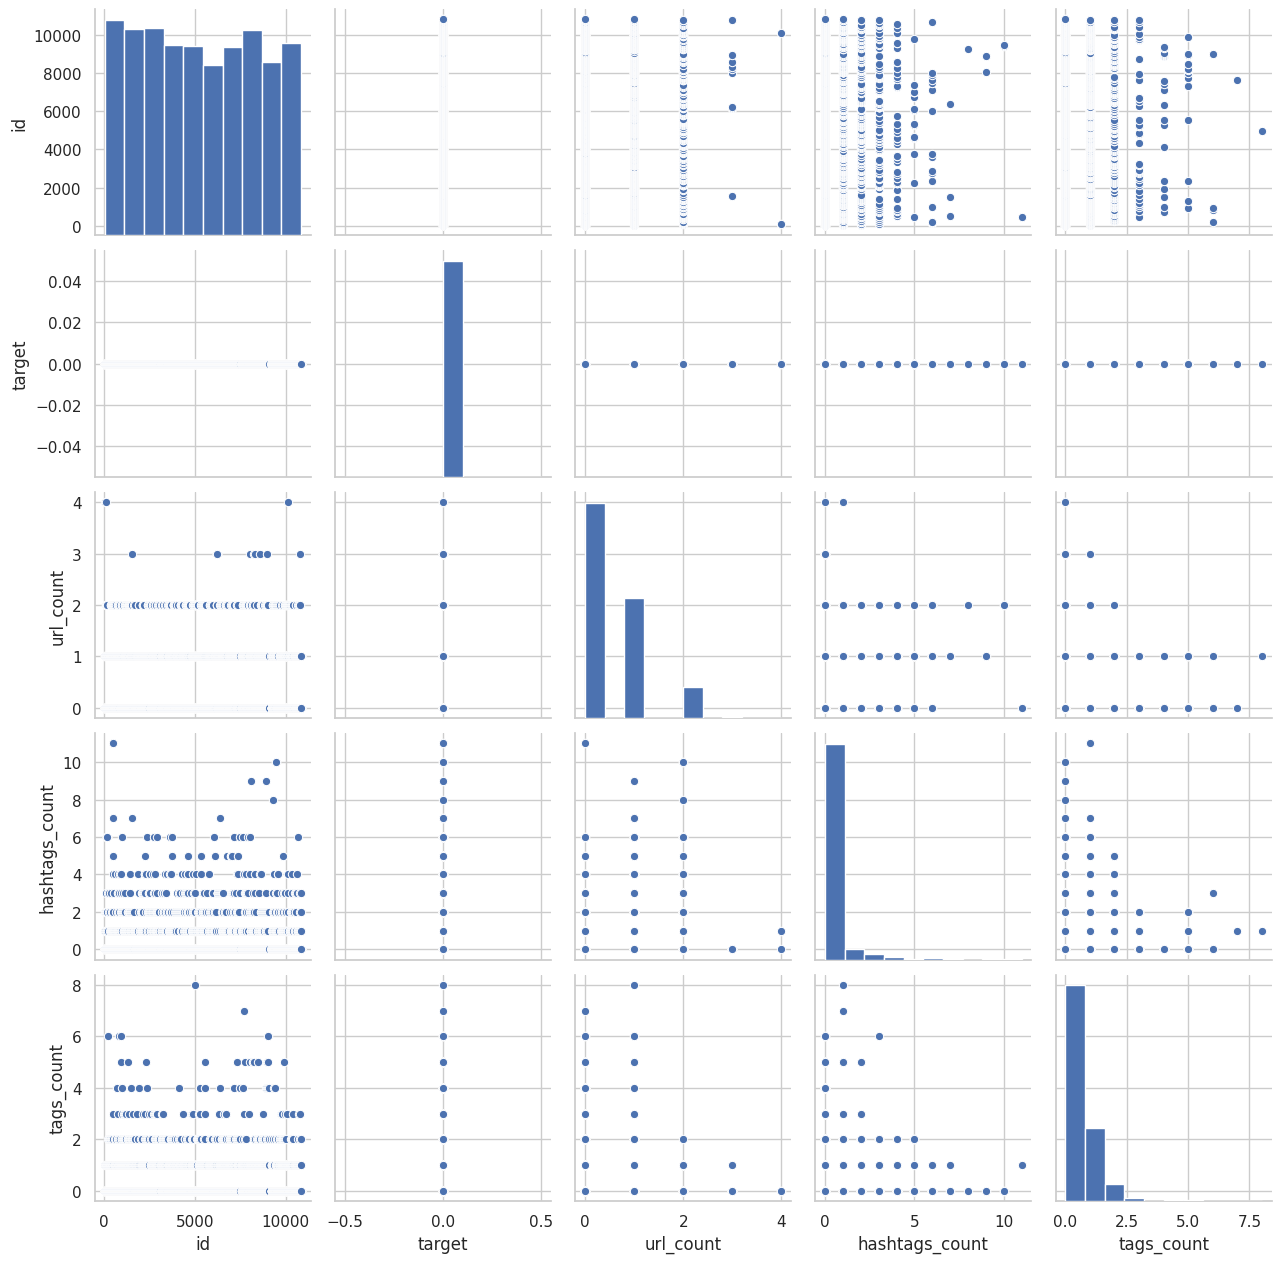

In [372]:
gsnum = sns.pairplot(tweets[tweets["target"] == 0].select_dtypes('number'))


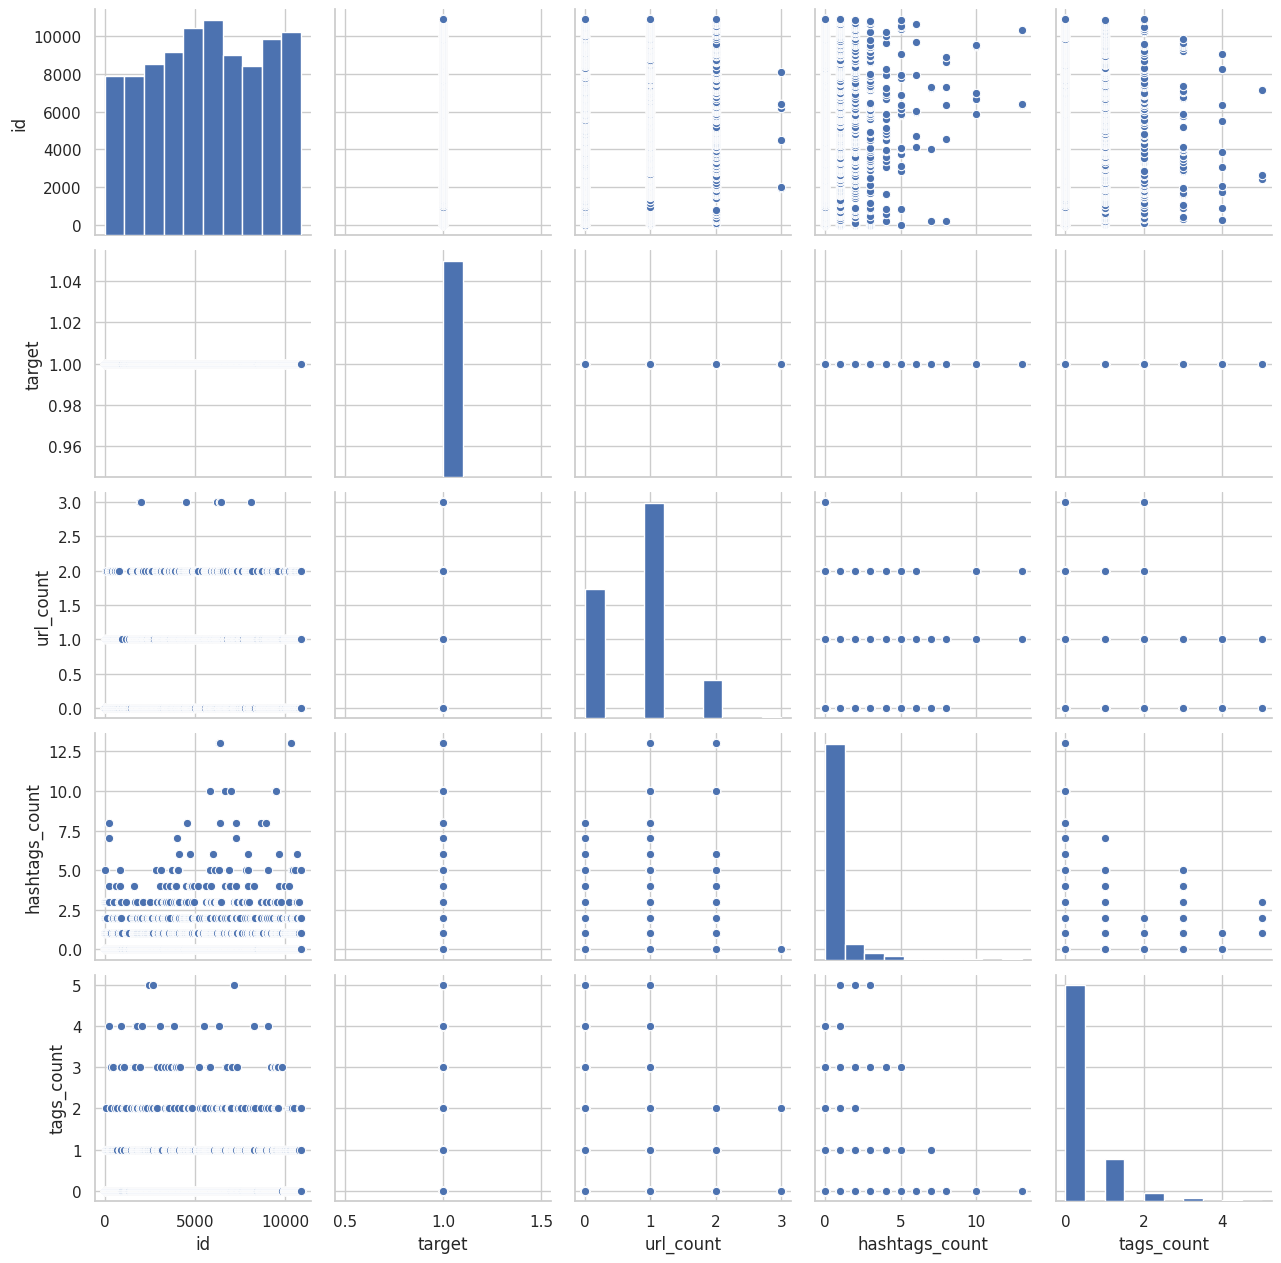

In [373]:
gsnum = sns.pairplot(tweets[tweets["target"] == 1].select_dtypes('number'))

### Relacion entre location y existencia en el texto.

In [413]:
tweets = tweets.fillna('None')

In [485]:
#casos excluidos (si no tienen location, obviamente no van a estar en el texto)
tweets['text_in_location'] = tweets[['text','location']].apply(lambda row: row.location in row.text ,axis = 1)
tweets['text_in_location'].value_counts()


False    7553
True       60
Name: text_in_location, dtype: int64

In [ ]:
#Imposible, muy pesado ejecutar esto...
#locations_series =tweets['location'].value_counts().index
#tweets['text_in_location'] = tweets[['text']].apply(lambda row: any(loc in row.text for loc in locations_series))
#tweets

In [482]:
#relacion entre veracidad y existencia de location
# grafico esto para ver si hay relación




In [486]:
#Graficos sobre series numericas.
tweets[tweets["target"] == 1].select_dtypes('number')

,id,target,url_count,hashtags_count,tags_count
0,1,1,0,1,0
1,4,1,0,0,0
2,5,1,0,0,0
3,6,1,0,1,0
4,7,1,0,2,0
...,...,...,...,...,...
7608,10869,1,1,0,0
7609,10870,1,0,0,2
7610,10871,1,1,0,0
7611,10872,1,0,0,0


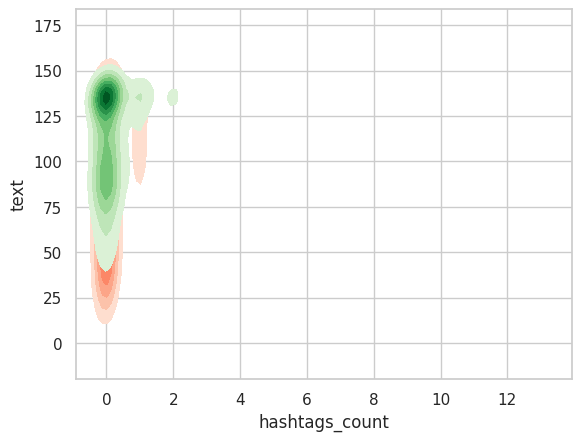

In [499]:
#Pendiente
ax = sns.kdeplot(tweets[tweets["target"] == 0].hashtags_count,tweets[tweets["target"] == 0].text.str.len() ,cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(tweets[tweets["target"] == 1].hashtags_count,tweets[tweets["target"] == 1].text.str.len(), cmap="Greens", shade=True, shade_lowest=False)
ax

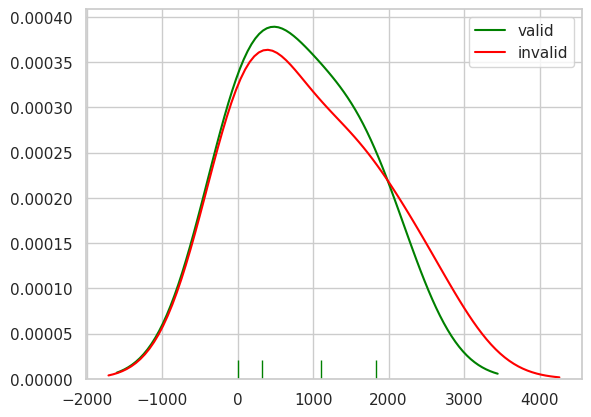

In [520]:

countUrl = pd.DataFrame() 
countUrl['valid'] = tweets[tweets["target"] == 1].url_count.value_counts()
countUrl['invalid'] = tweets[tweets["target"] == 0].url_count.value_counts()
#countHashtags['valid'] = tweets[tweets["target"] == 1].hashtags_count.value_counts()
#countHashtags['invalid'] = tweets[tweets["target"] == 0].hashtags_count.value_counts()
#countTags['valid'] = tweets[tweets["target"] == 1].tags_count.value_counts()
#countTags['invalid'] = tweets[tweets["target"] == 0].tags_count.value_counts()

#countUrl

#sns.distplot(target_0[['sepal length (cm)']], hist=False, rug=True)

g = sns.distplot(countUrl[['valid']], color="green",label="valid",hist=False,rug=True)
g = sns.distplot(countUrl, color="red",label="invalid",hist=False)
g